In [1]:
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

from packages.quantum_error_correction import *

from functools import partial
from jax import jit, random, vmap
import jax.numpy as jnp

key = random.key(42)

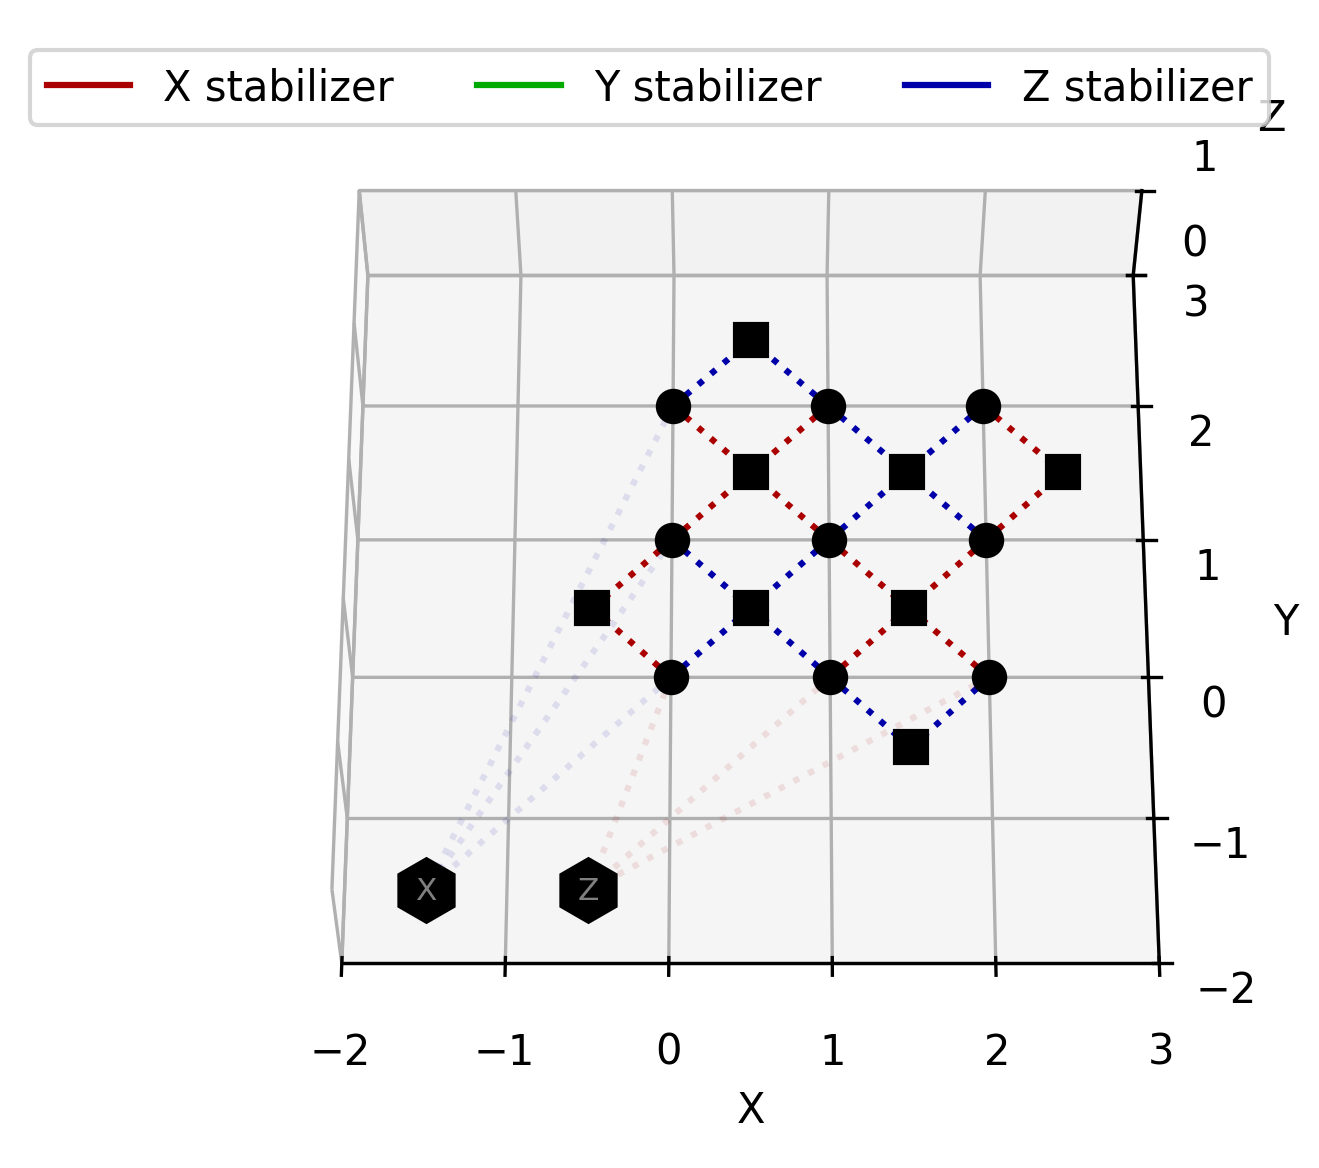

In [2]:
code_distance = 3

qec = QEC(surface_code_data_wls(d=code_distance))
info = {}
Hx, Hy, Hz = qec.transformation_matrix()
# Split into matrix for syndrome qubits in logical detectors
H_syndrome={'x': Hx[:-2], 'y': Hy[:-2], 'z': Hz[:-2]}
H_logicals={'x': Hx[-2:], 'y': Hy[-2:], 'z': Hz[-2:]}
nsq, ndq = H_syndrome['x'].shape
qec.show();

# Perfect Surface Code distance 3 Decoder (PSC3D) class

In [3]:
class PSC3D:

    def __init__(
        self,
        H_syndrome: dict,
        H_logicals: dict,
    ):
        """Perfect SC3 decoder + lowest possible SC3 logical error rates"""
        def _syndrome_logicals(
            error,
        ):
            syndrome = (
                jnp.matmul(H_syndrome['x'], error == 1, preferred_element_type=jnp.int32) +
                jnp.matmul(H_syndrome['y'], error == 2, preferred_element_type=jnp.int32) +
                jnp.matmul(H_syndrome['z'], error == 3, preferred_element_type=jnp.int32)
            ) % 2
            logicals = (
                jnp.matmul(H_logicals['x'], error == 1, preferred_element_type=jnp.int32) +
                jnp.matmul(H_logicals['y'], error == 2, preferred_element_type=jnp.int32) +
                jnp.matmul(H_logicals['z'], error == 3, preferred_element_type=jnp.int32)
            ) % 2
            return syndrome, logicals
        
        def _error_to_prob(
            probability: jnp.ndarray,
            qubit_errors: jnp.ndarray,
        ):
            return probability[qubit_errors]
        
        self._error_to_prob_batch = vmap(
            _error_to_prob,
            in_axes=[0, 1],
            out_axes=1
        )
            
        all_errors_idx = jnp.zeros(shape=(4**9,9), dtype=jnp.int32) + jnp.arange(0,4**9)[:, None]
        self.all_errors = (all_errors_idx // 4**jnp.arange(0,9)) % 4
        batch_syndrome_logicals = vmap(_syndrome_logicals)
        self.all_syndrome, self.all_logicals = batch_syndrome_logicals(self.all_errors)
        self.syndrome_idx = jnp.dot(self.all_syndrome, 2**jnp.arange(0,8))
        self.logicals_idx = jnp.dot(self.all_logicals, 2**jnp.arange(0,2))

        self.deformation_transformations = jnp.array([
            [0,1,2,3], # I
            [0,2,1,3], # X-Y
            [0,1,3,2], # Y-Z
            [0,3,2,1], # X-Z
            [0,2,3,1], # X-Y-Z
            [0,3,1,2], # X-Z-Y
        ])
    

    def logical_error_rate(
        self,
        noise_model: jnp.ndarray,
        deformation: jnp.ndarray,
    ):
        # Deform the noise model
        code_deformation = self.deformation_transformations[deformation]
        data_qubit_error_idx = jnp.zeros_like(code_deformation, dtype=int) + jnp.arange(0,deformation.shape[0])[:, None]
        noise_model = noise_model[(data_qubit_error_idx, code_deformation)]

        # Calculate the probabilily that we will have a given syndrome with a given logical
        likelyhood = jnp.prod(self._error_to_prob_batch(noise_model, self.all_errors), axis=1)
        record = jnp.zeros(shape=(2**8,4), dtype=jnp.float32)
        record = record.at[(self.syndrome_idx, self.logicals_idx)].add(likelyhood)

        # Rearage result acording to most likely decoding
        #    Logical error:            [0,0]     [1,0]     [0,1]     [1,1]
        rearange_lookup = jnp.array([[0,1,2,3],[1,0,3,2],[2,3,0,1],[3,2,1,0]])
        rearange = rearange_lookup[record.argmax(axis=1)]
        record_rearanged = record[(jnp.arange(0, 2**8)[:,None], rearange)]
        
        # Calculate the logical error rates
        logical_error_rates = record_rearanged.sum(axis=0)
        # Fix order from IXZY to IXYZ
        logical_error_rates = logical_error_rates[jnp.array([0,1,3,2])]
        return logical_error_rates
    

    def decode(
        self,
        syndrome: jnp.ndarray,
        noise_model: jnp.ndarray,
        deformation: jnp.ndarray,
    ):
        # Deform the noise model
        code_deformation = self.deformation_transformations[deformation]
        data_qubit_error_idx = jnp.zeros_like(code_deformation, dtype=int) + jnp.arange(0,deformation.shape[0])[:, None]
        noise_model = noise_model[(data_qubit_error_idx, code_deformation)]

        # Find all the errors with the given syndrome
        active_syndrome_idx = jnp.dot(syndrome, 2**jnp.arange(0,8))
        possible_errors = self.all_errors[jnp.where(self.syndrome_idx == active_syndrome_idx)]

        # Calculate their likelyhood
        likelyhood = jnp.prod(self._error_to_prob_batch(noise_model, possible_errors), axis=1)
        if likelyhood.max() == 0:
            raise ValueError("There are no possible explanation of the error with the given nois model.")
        
        # Pick the most likely one as the recovery operation
        recodery = possible_errors[likelyhood.argmax()]
        return recodery
    

    def decode_batch(
        self,
        syndromes: jnp.ndarray,
        noise_model: jnp.ndarray,
        deformation: jnp.ndarray,
    ):
        batch_decode = vmap(
            self.decode,
            in_axes=[0, None, None],
            out_axes=0
        )
        return batch_decode(syndromes, noise_model, deformation)

perfect_decoder = PSC3D(H_syndrome, H_logicals)

In [4]:
print(H_logicals)

{'x': array([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'y': array([[1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0.]]), 'z': array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0.]])}


# Random Clifford deformation

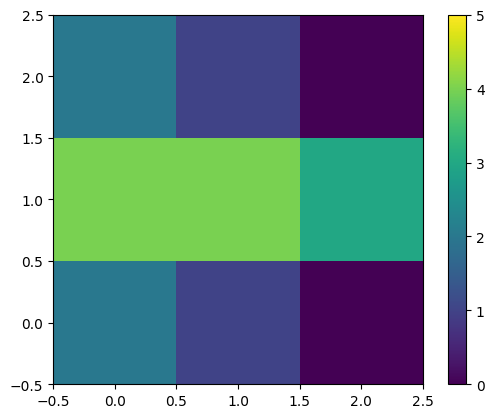

In [5]:
# Pick a random clifford deformation
subkey, key = jax.random.split(key)
random_deformation = jax.random.randint(subkey, shape=ndq, minval=0, maxval=6)
no_deformation = jnp.array([0,0,0,0,0,0,0,0,0])
C1_deformation = jnp.array([2,3,2,0,2,0,2,3,2])
XZZX_deformation = jnp.array([3,0,3,0,3,0,3,0,3])
ZY_deformation = jnp.array([2,2,2,2,2,2,2,2,2])

plt.figure()
plt.imshow(random_deformation.reshape(3,3).T, origin='lower', vmin=0, vmax=5)
plt.colorbar()
plt.show()

In [6]:
used_deformations = jnp.array([0,2,3])
all_deformation_idx = jnp.zeros(shape=(used_deformations.shape[0]**9,9), dtype=jnp.int32) + jnp.arange(0,used_deformations.shape[0]**9)[:, None]
all_deformations = (all_deformation_idx // used_deformations.shape[0]**jnp.arange(0,9)) % used_deformations.shape[0]
all_deformations = used_deformations[all_deformations]
all_deformations

Array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 3, 3, ..., 3, 3, 3],
       [2, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=int32)

In [7]:
from time import time
t0 = time()

p_tot = .01
nu = 500
error_prob = [
    1 / (2 * (nu + 1)) * p_tot,
    1 / (2 * (nu + 1)) * p_tot,
    nu / (nu + 1) * p_tot,
]
print(error_prob)
physical_error_rates = jnp.array([1-sum(error_prob), *error_prob])
error_probs=jnp.ones(shape=(9,4))*physical_error_rates
logical_error_rates_batch = vmap(
    perfect_decoder.logical_error_rate,
    in_axes=[None, 0],
    out_axes=0
)
all_logical_error_rates = jnp.zeros(shape=[all_deformations.shape[0], 4])
batch_size = 81
for i, deformations_batch in enumerate(all_deformations.reshape((all_deformations.shape[0] // batch_size, batch_size, 9))):
    all_logical_error_rates = all_logical_error_rates.at[i*batch_size:(i+1)*batch_size].set(
        logical_error_rates_batch(error_probs, deformations_batch)
    )
    procentage = (i+1) / (all_deformations.shape[0] // batch_size)
    remaining_time = (time()-t0) / procentage * (1 - procentage)
    print(f"{int(remaining_time/60/60):5d}h {int(remaining_time/60%60):02d}m {int(remaining_time%60):02d}s", end='\r')
    # print(f"{i+1}/{all_deformations.shape[0] // batch_size}", end='\r')

[9.98003992015968e-06, 9.98003992015968e-06, 0.00998003992015968]


In [8]:
# specifier = "UD023_p01_nu500"
# jnp.save(f"all_logical_error_rates_{specifier}", all_logical_error_rates)
# jnp.save(f"all_deformations_{specifier}", all_deformations)

In [9]:
count_yz = jnp.where(all_deformations == 2, 1, 0).sum(axis=1)
count_xz = jnp.where(all_deformations == 3, 1, 0).sum(axis=1)
similarity = (all_deformations != C1_deformation).sum(axis=1)

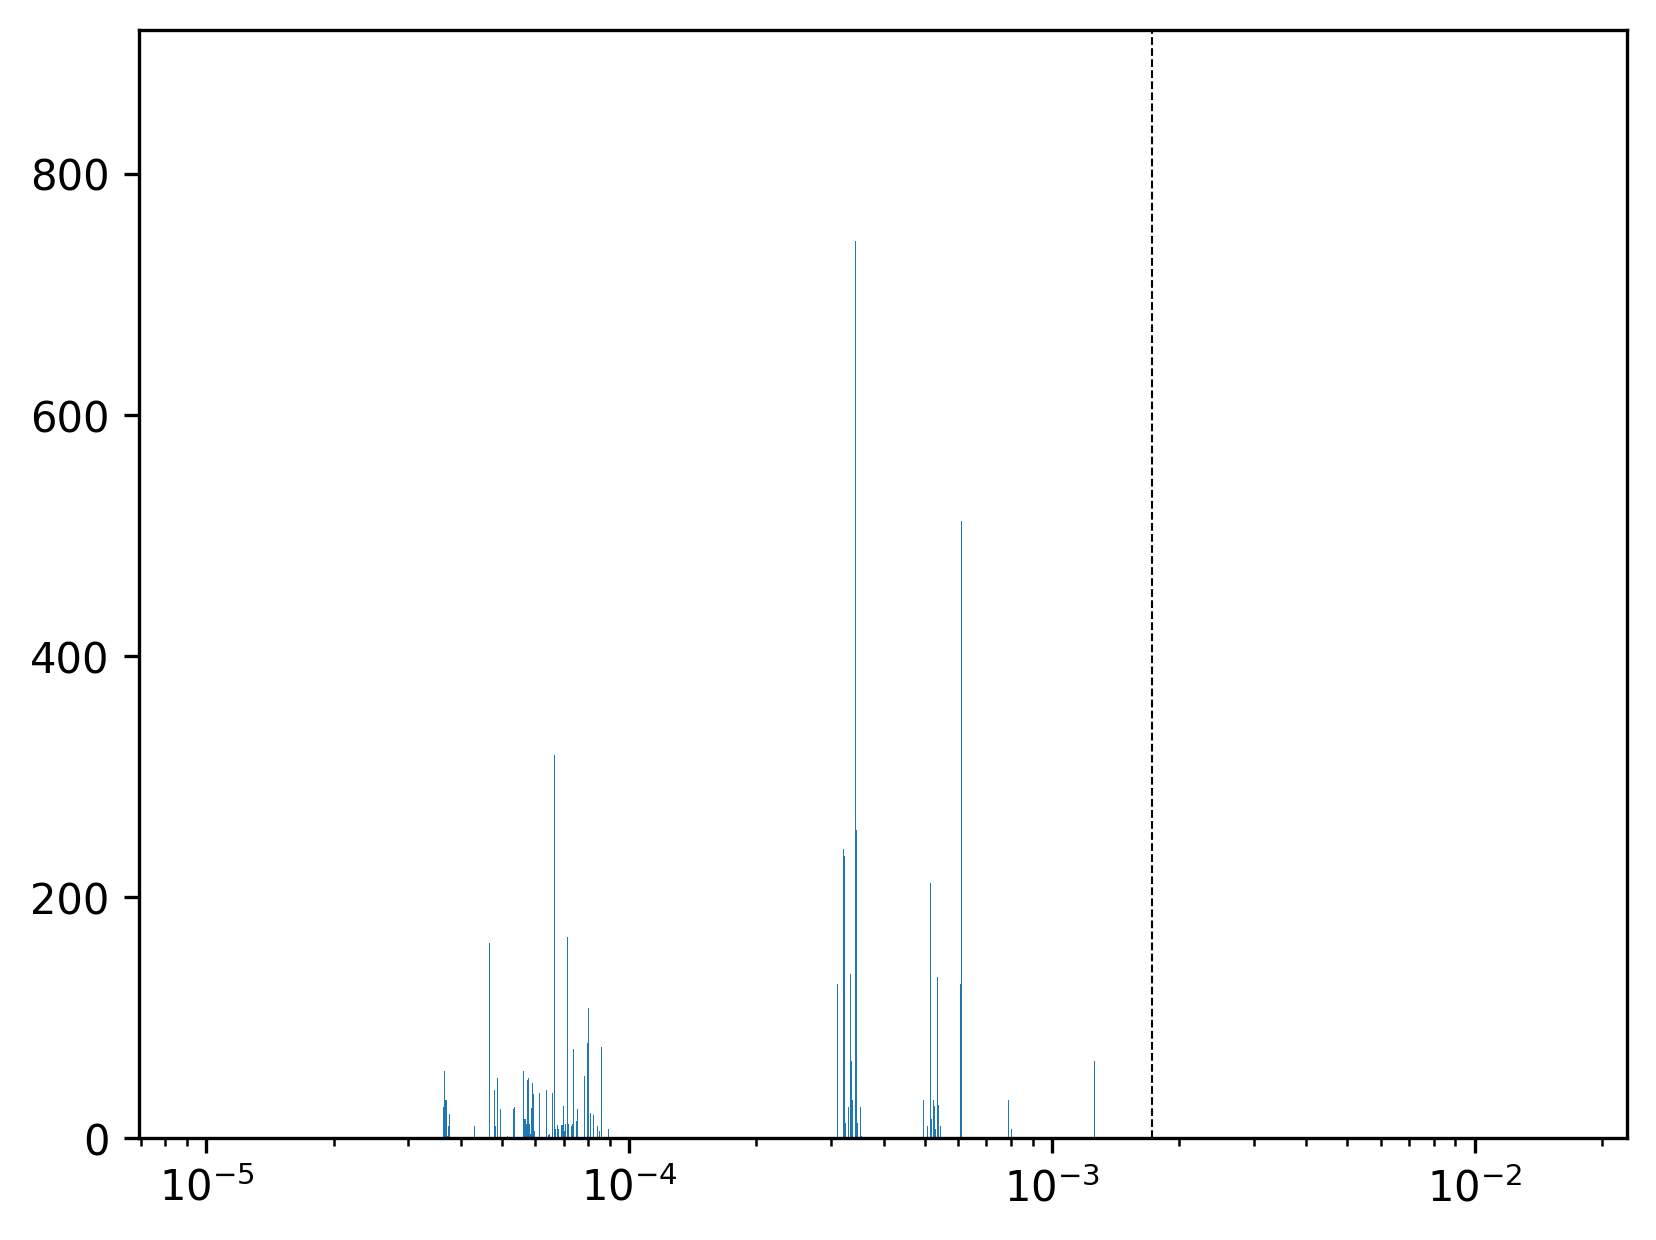

In [10]:
total_logical_error_rate = 1-all_logical_error_rates[:,0]
plt.figure(dpi=300)
plt.hist(total_logical_error_rate, bins=jnp.logspace(-5, -1.8, 5000))
ylim = plt.gca().get_ylim()
plt.ylim(ylim)
plt.vlines([total_logical_error_rate[0]], [ylim[0]], [ylim[1]], color='k', ls='--', lw=.5, zorder=-1)
plt.xscale('log')
plt.show()

In [11]:
total_logical_error_rate.min()

Array(2.4974346e-05, dtype=float32)

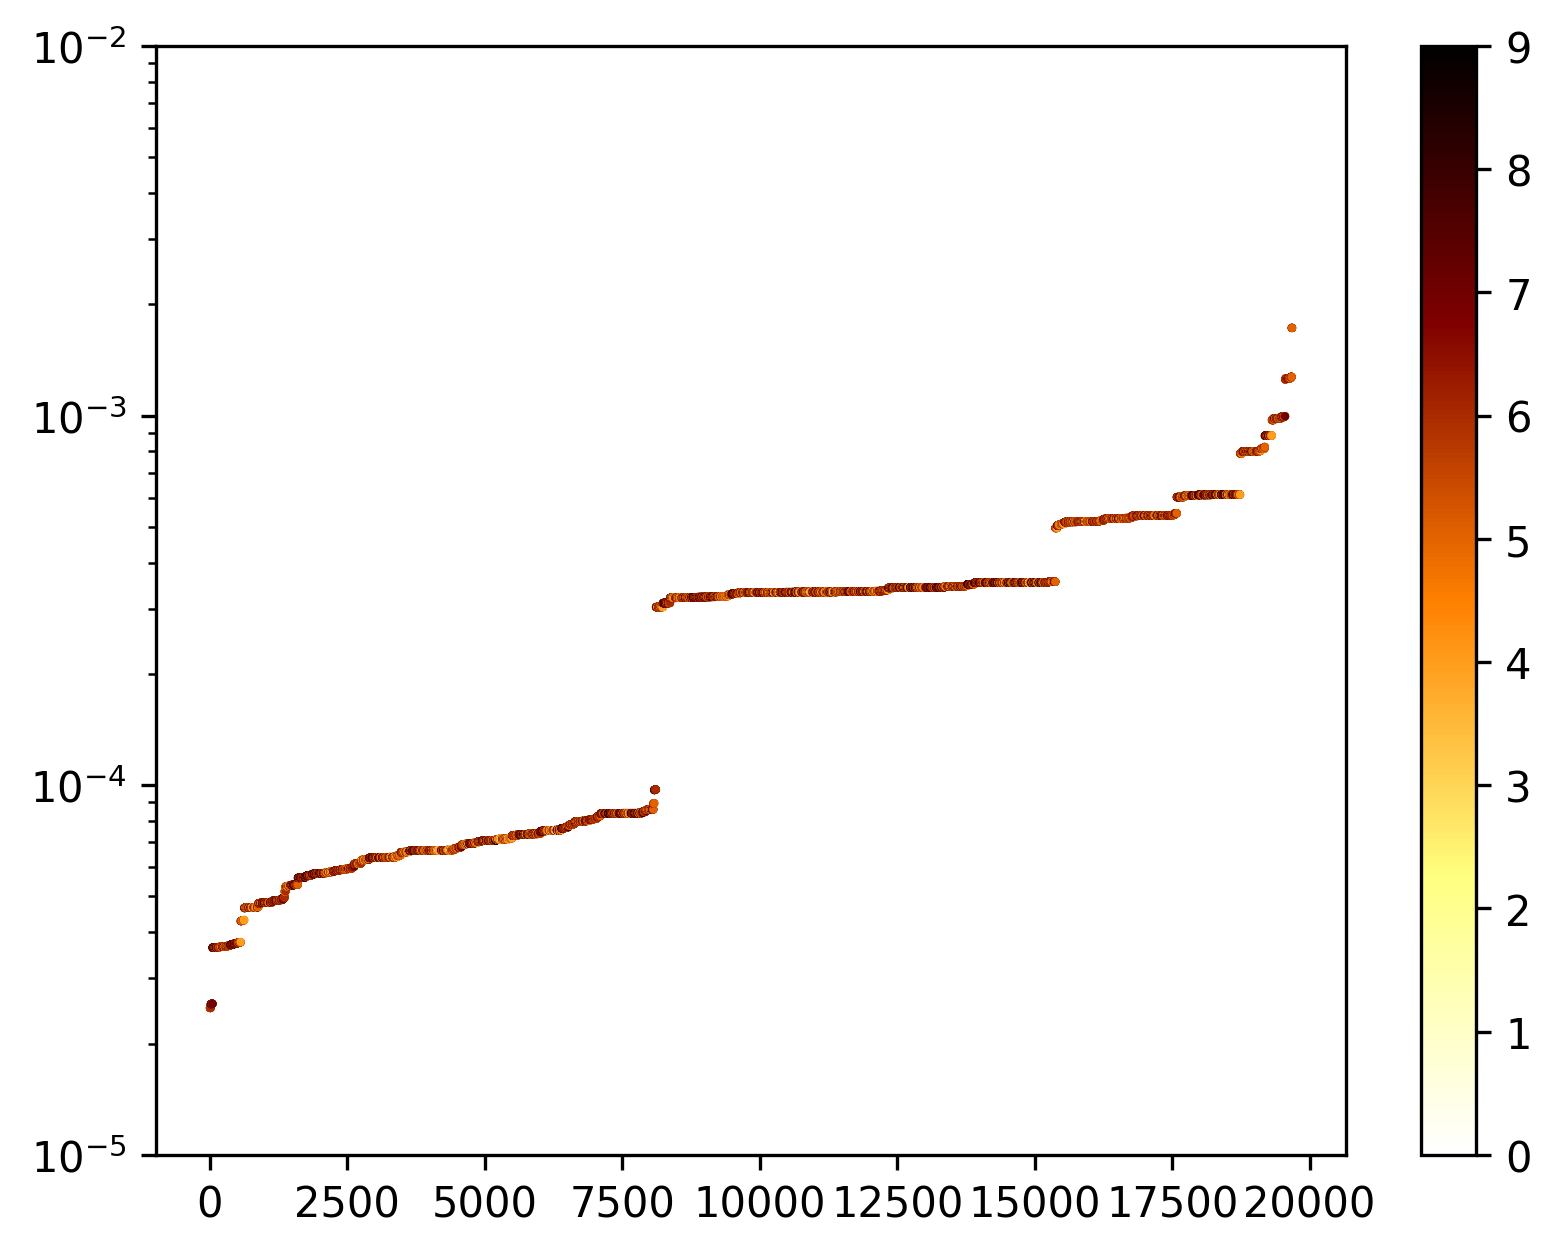

In [12]:
# sorted_idx = jnp.arange(0, total_logical_error_rate.shape[0])
sorted_idx = total_logical_error_rate.argsort()
plt.figure(dpi=300)
plt.scatter(
    # x=similarity, 
    x=jnp.arange(0, sorted_idx.shape[0]), 
    y=total_logical_error_rate[sorted_idx], 
    s=1, 
    c=similarity[sorted_idx], 
    cmap='afmhot_r')
plt.colorbar()
plt.yscale('log')
plt.ylim(1E-5, 1E-2)
plt.show()

In [13]:
jnp.where(total_logical_error_rate < 2.5E-5)[0].shape

(16,)

In [14]:
mask = total_logical_error_rate < 5E-5
worst = total_logical_error_rate[mask].argmax()
all_deformations[mask][worst]

Array([2, 0, 2, 2, 0, 2, 2, 2, 0], dtype=int32)

In [15]:
for idx in jnp.where(total_logical_error_rate < 2.5E-5)[0]:
    print(f"\n{idx = }")
    display(all_deformations[idx])
    print(all_deformations[idx].reshape((3,3)).T)


idx = Array(3313, dtype=int32)


Array([2, 0, 3, 3, 2, 2, 2, 2, 0], dtype=int32)

[[2 3 2]
 [0 2 2]
 [3 2 0]]

idx = Array(3315, dtype=int32)


Array([0, 2, 3, 3, 2, 2, 2, 2, 0], dtype=int32)

[[0 3 2]
 [2 2 2]
 [3 2 0]]

idx = Array(3547, dtype=int32)


Array([2, 0, 2, 3, 2, 3, 2, 2, 0], dtype=int32)

[[2 3 2]
 [0 2 2]
 [2 3 0]]

idx = Array(3549, dtype=int32)


Array([0, 2, 2, 3, 2, 3, 2, 2, 0], dtype=int32)

[[0 3 2]
 [2 2 2]
 [2 3 0]]

idx = Array(4015, dtype=int32)


Array([2, 0, 3, 2, 2, 2, 3, 2, 0], dtype=int32)

[[2 2 3]
 [0 2 2]
 [3 2 0]]

idx = Array(4017, dtype=int32)


Array([0, 2, 3, 2, 2, 2, 3, 2, 0], dtype=int32)

[[0 2 3]
 [2 2 2]
 [3 2 0]]

idx = Array(4249, dtype=int32)


Array([2, 0, 2, 2, 2, 3, 3, 2, 0], dtype=int32)

[[2 2 3]
 [0 2 2]
 [2 3 0]]

idx = Array(4251, dtype=int32)


Array([0, 2, 2, 2, 2, 3, 3, 2, 0], dtype=int32)

[[0 2 3]
 [2 2 2]
 [2 3 0]]

idx = Array(7687, dtype=int32)


Array([2, 0, 3, 3, 2, 2, 2, 0, 2], dtype=int32)

[[2 3 2]
 [0 2 0]
 [3 2 2]]

idx = Array(7689, dtype=int32)


Array([0, 2, 3, 3, 2, 2, 2, 0, 2], dtype=int32)

[[0 3 2]
 [2 2 0]
 [3 2 2]]

idx = Array(7921, dtype=int32)


Array([2, 0, 2, 3, 2, 3, 2, 0, 2], dtype=int32)

[[2 3 2]
 [0 2 0]
 [2 3 2]]

idx = Array(7923, dtype=int32)


Array([0, 2, 2, 3, 2, 3, 2, 0, 2], dtype=int32)

[[0 3 2]
 [2 2 0]
 [2 3 2]]

idx = Array(8389, dtype=int32)


Array([2, 0, 3, 2, 2, 2, 3, 0, 2], dtype=int32)

[[2 2 3]
 [0 2 0]
 [3 2 2]]

idx = Array(8391, dtype=int32)


Array([0, 2, 3, 2, 2, 2, 3, 0, 2], dtype=int32)

[[0 2 3]
 [2 2 0]
 [3 2 2]]

idx = Array(8623, dtype=int32)


Array([2, 0, 2, 2, 2, 3, 3, 0, 2], dtype=int32)

[[2 2 3]
 [0 2 0]
 [2 3 2]]

idx = Array(8625, dtype=int32)


Array([0, 2, 2, 2, 2, 3, 3, 0, 2], dtype=int32)

[[0 2 3]
 [2 2 0]
 [2 3 2]]


In [16]:
jnp.where(total_logical_error_rate < 3E-5)[0].shape

(48,)

In [17]:
from matplotlib.colors import ListedColormap
deformation_cmap = ListedColormap([
    "#FFFFFF", # I
    "#88C946", # X-Y
    "#C43119", # Y-Z
    "#00ADE7", # X-Z
    "#833794", # X-Y-Z
    "#FFB94C", # X-Z-Y
])

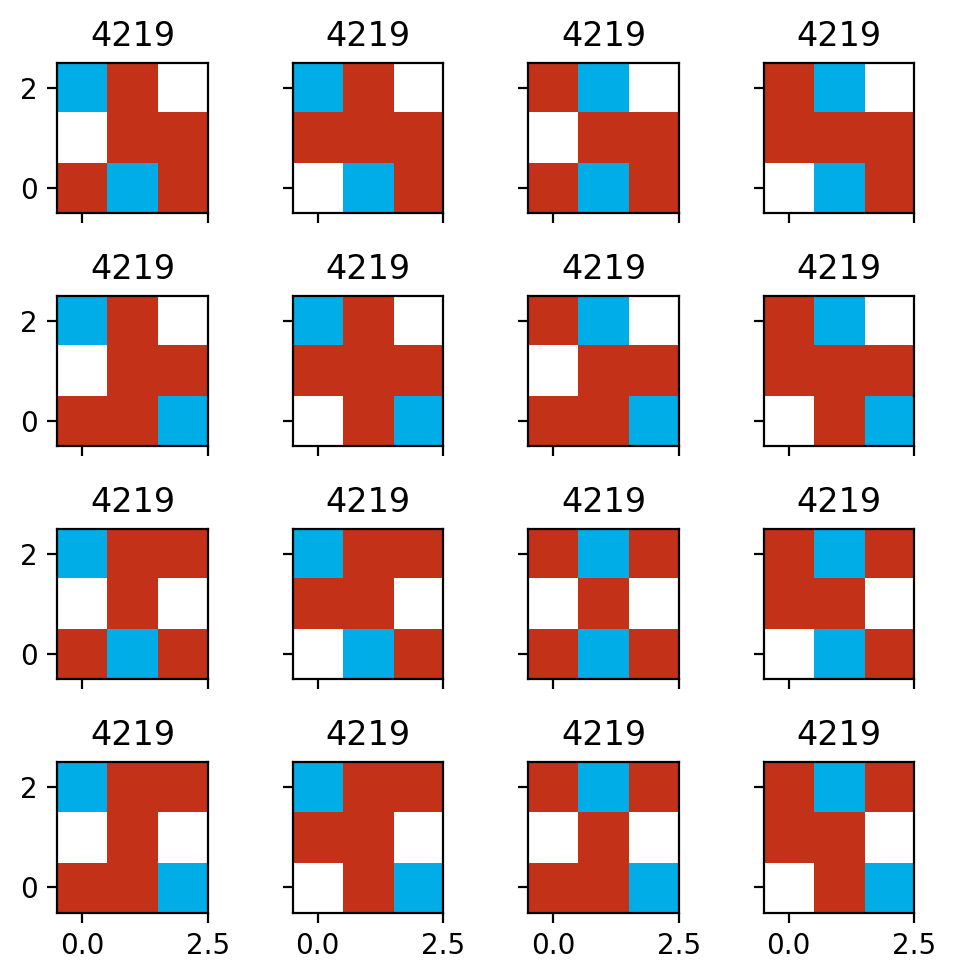

In [20]:
fig, ax = plt.subplots(4,4, sharex=True, sharey=True, dpi=200)
fig.set_figwidth(5)
fig.set_figheight(5)
for i, idx_row in enumerate(jnp.where(total_logical_error_rate < 2.5E-5)[0].reshape(4,4)):
    for j, idx in enumerate(idx_row):
        ax[i][j].set_title(f"{-jnp.log(.9)/total_logical_error_rate[idx]:.0f}")
        ax[i][j].imshow(all_deformations[idx].reshape((3,3)).T, origin='lower', vmin=0, vmax=5, cmap=deformation_cmap)
plt.tight_layout()

# Find best possible logical error rates

In [21]:
print("The worst found deformation is:")
print(all_deformations[total_logical_error_rate.argmax()].reshape((3,3)).T)
print("The best found deformation is:")
print(all_deformations[total_logical_error_rate.argmin()].reshape((3,3)).T)
print("Most uniform logical error rate distribution:")
print(all_deformations[all_logical_error_rates[:,1:].std(axis=1).argmin()].reshape((3,3)).T)

The worst found deformation is:
[[0 0 0]
 [0 0 0]
 [0 0 0]]
The best found deformation is:
[[2 3 2]
 [0 2 2]
 [3 2 0]]
Most uniform logical error rate distribution:
[[3 2 0]
 [3 2 2]
 [0 0 3]]


In [22]:
logical_error_rates = perfect_decoder.logical_error_rate(
    noise_model=error_probs, 
    deformation=no_deformation
)
for l_rate, f_rate, name in zip(logical_error_rates, physical_error_rates, "IXYZ"):
    print(f"Logical error rate for {name} = {l_rate:8.3%} vs {f_rate:8.3%}, improvement = {f_rate/l_rate:6.2f}X")
print(f"Total logical error rate = {1-logical_error_rates[0]:8.3%} vs {1-physical_error_rates[0]:8.3%}, improvement = {(1-physical_error_rates[0])/(1-logical_error_rates[0]):6.2f}X")

Logical error rate for I =  99.827% vs  99.000%, improvement =   0.99X
Logical error rate for X =   0.000% vs   0.001%, improvement = 1471.96X
Logical error rate for Y =   0.000% vs   0.001%, improvement = 25550.03X
Logical error rate for Z =   0.173% vs   0.998%, improvement =   5.78X
Total logical error rate =   0.173% vs   1.000%, improvement =   5.79X


In [23]:
logical_error_rates = perfect_decoder.logical_error_rate(
    noise_model=error_probs, 
    deformation=C1_deformation
)
for l_rate, f_rate, name in zip(logical_error_rates, physical_error_rates, "IXYZ"):
    print(f"Logical error rate for {name} = {l_rate:8.3%} vs {f_rate:8.3%}, improvement = {f_rate/l_rate:6.2f}X")
print(f"Total logical error rate = {1-logical_error_rates[0]:8.3%} vs {1-physical_error_rates[0]:8.3%}, improvement = {(1-physical_error_rates[0])/(1-logical_error_rates[0]):6.2f}X")

Logical error rate for I =  99.992% vs  99.000%, improvement =   0.99X
Logical error rate for X =   0.003% vs   0.001%, improvement =   0.30X
Logical error rate for Y =   0.001% vs   0.001%, improvement =   1.02X
Logical error rate for Z =   0.003% vs   0.998%, improvement = 301.92X
Total logical error rate =   0.008% vs   1.000%, improvement = 132.21X


# Random error that produce a specific syndrome and logical

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

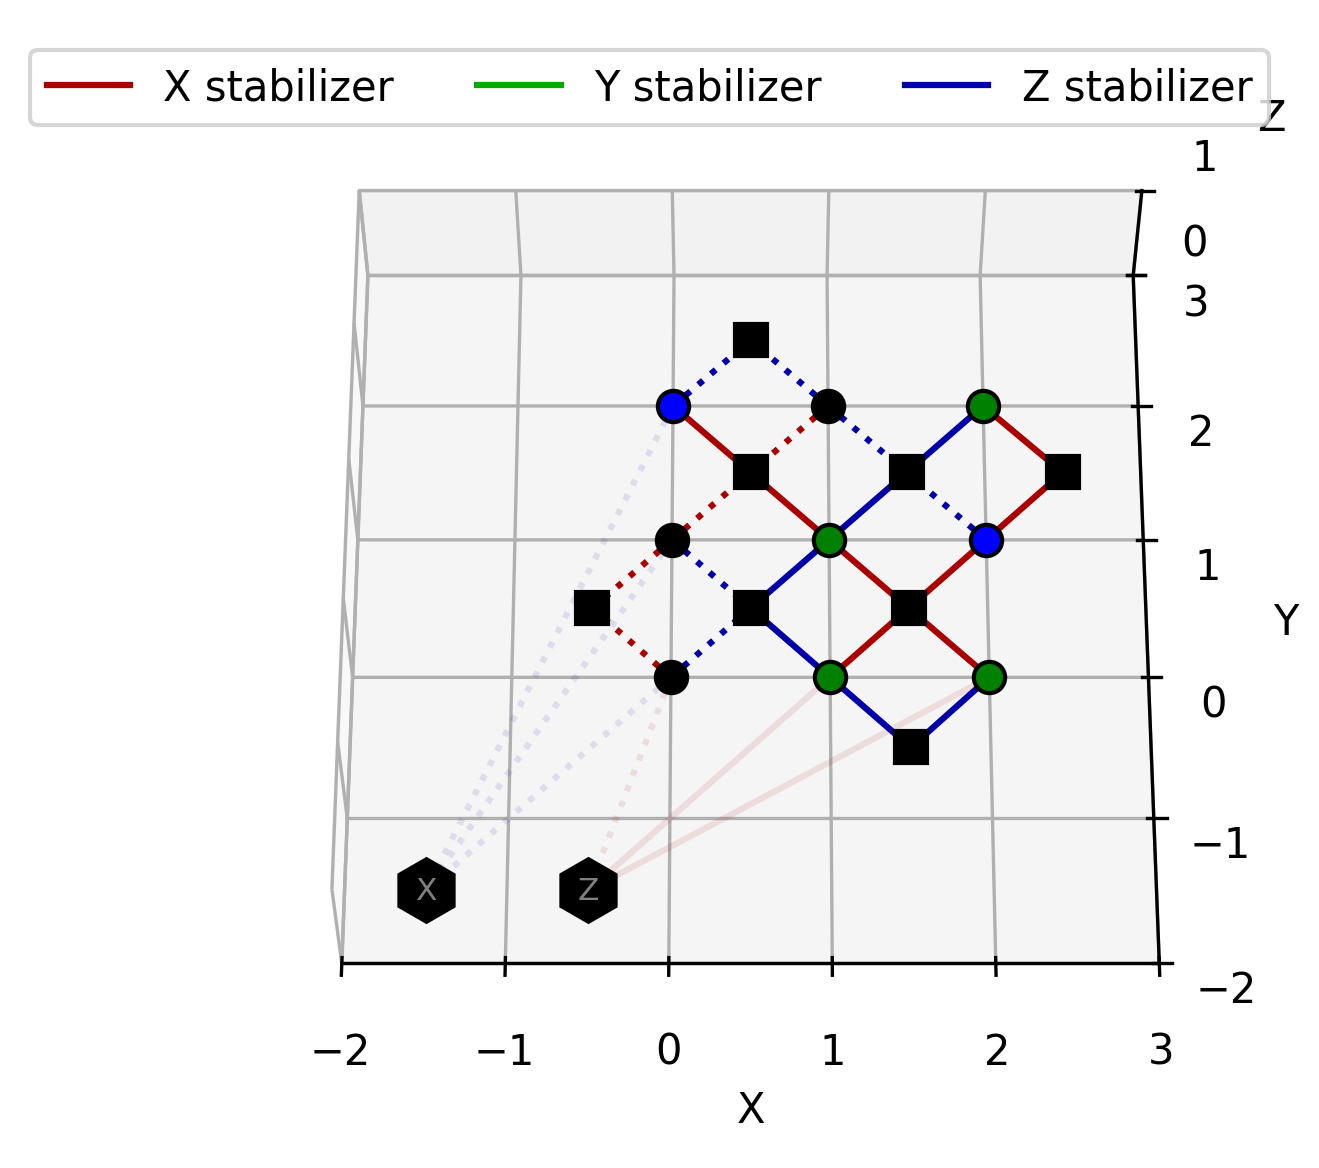

In [24]:
idxs = jnp.where(jnp.logical_and(
    perfect_decoder.syndrome_idx == 0,
    perfect_decoder.logicals_idx == 0    
))
errors = perfect_decoder.all_errors[idxs]

subkey, key = random.split(key)
i = random.randint(subkey, shape=1, minval=0, maxval=errors.shape[0])[0]

qec.show(errors=errors[i])

# Decoding

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

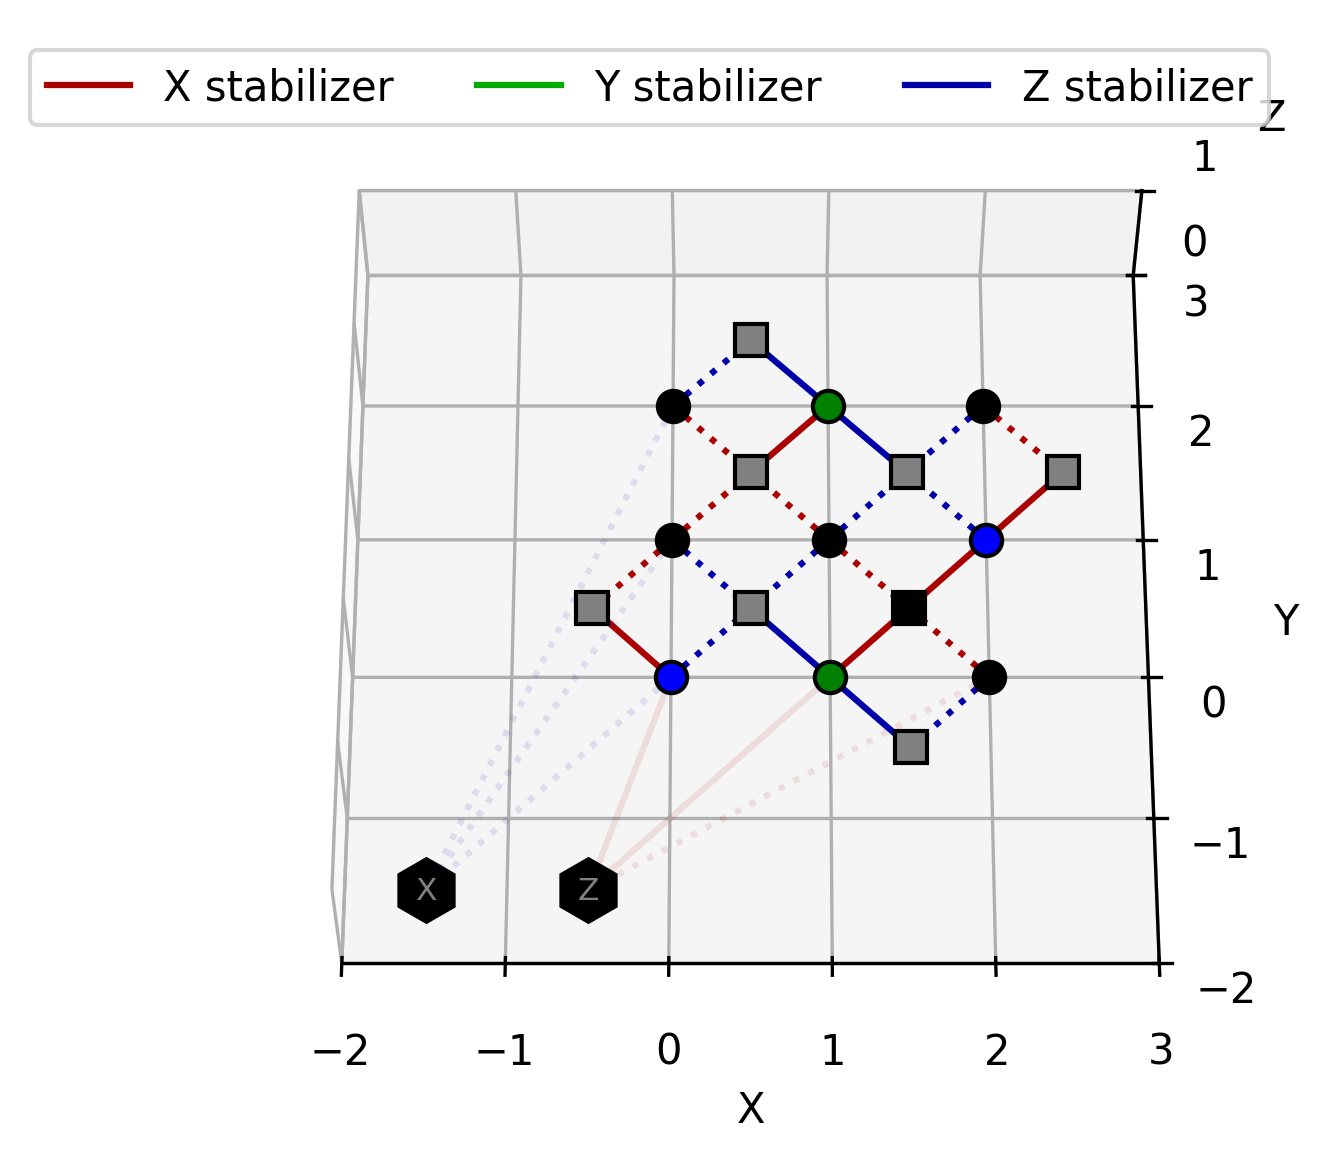

In [25]:
px, py, pz = .0001, .001, .01
error_probs=jnp.ones(shape=(9,4))*jnp.array([1-px-py-pz, px, py, pz])
syndrome = jnp.array([1, 1, 1, 1, 1, 0, 1, 1], dtype=jnp.int32)
recovery = perfect_decoder.decode(
    syndrome=syndrome, 
    noise_model=error_probs,
    deformation=no_deformation
)
qec.show(errors=recovery)